In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

from b2heavy.FnalHISQMetadata import params as mData

In [13]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
# DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

JKFIT = True

In [14]:
ENSEMBLE_LIST = ['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys','Fine-1','Fine-Phys','SuperFine']
MOMLIST       = ['000','100','200','300','400']
RATIO_LIST    = ['XF','RPLUS','RMINUS','QPLUS']

In [15]:
Rs = []
jk = {}
for ens in ENSEMBLE_LIST:
    jk[ens] = {}
    for mom in MOMLIST:
        aux = {'ensemble':ens, 'mom':mom}
        jk[ens][mom] = {}
        for rat in RATIO_LIST:
            if (mom=='000' and rat!='RPLUS') or (mom!='000' and rat=='RPLUS'):
                continue
            else:
                try:
                    res = read_config_fit(
                        tag  = f'fit3pt_config_{ens}_{rat}_{mom}',
                        path = DATA_2PT,
                        jk   = JKFIT
                    )
                    f0 = res['ratio'][0] if JKFIT else res[-1]['ratio'][0]
                    if JKFIT:
                        jk[ens][mom][rat] = f0
                        r = gv.gvar(f0.mean(),f0.std()*np.sqrt(len(f0)-1))
                    else:
                        r = f0

                except FileNotFoundError:
                    continue
        
            aux[rat] = r
        Rs.append(aux)

df = pd.DataFrame(Rs).set_index(['ensemble','mom'])
df = df.drop(('Coarse-1','400'))
df = df.drop(('Coarse-2','400'))

In [16]:
df

RPLUS            XF        RMINUS       QPLUS
ensemble     mom                                                    
MediumCoarse 000   1.048(20)           NaN           NaN         NaN
             100         NaN   -0.0717(13)   -0.0823(17)  0.9878(46)
             200         NaN   -0.1402(19)   -0.1575(26)  0.9595(97)
             300         NaN   -0.1994(32)   -0.2217(34)   0.920(16)
             400         NaN    -0.243(11)    -0.266(15)   0.888(17)
Coarse-2     000  1.0251(97)           NaN           NaN         NaN
             100         NaN   -0.1175(25)   -0.1333(26)  0.9758(27)
             200         NaN   -0.2235(38)   -0.2505(67)   0.943(20)
             300         NaN   -0.3082(71)    -0.331(12)   0.889(42)
Coarse-1     000  1.0063(42)           NaN           NaN         NaN
             100         NaN   -0.0920(36)   -0.0996(21)  0.9877(36)
             200         NaN   -0.1754(52)   -0.1914(49)  0.9524(65)
             300         NaN   -0.2468(62)   -0.2688(72)   0.896(21)
Coarse-Phys  000  1.0151(60)           NaN           NaN         NaN
             100         NaN   -0.0625(11)   -0.0692(14)  0.9951(14)
             200         NaN   -0.1218(14)   -0.1339(18)  0.9792(27)
             300         NaN   -0.1764(19)   -0.1945(27)  0.9512(53)
             400         NaN   -0.2248(29)   -0.2469(46)   0.918(14)
Fine-1       000  1.0350(58)           NaN           NaN         NaN
             100         NaN   -0.0770(10)   -0.0880(26)  0.9814(30)
             200         NaN   -0.1543(14)   -0.1848(56)  0.9497(55)
             300         NaN   -0.2262(22)   -0.2649(78)  0.9137(90)
             400         NaN   -0.2919(39)   -0.3314(97)   0.870(14)
Fine-Phys    000  1.0215(30)           NaN           NaN         NaN
             100         NaN  -0.06318(91)   -0.0670(12)  0.9944(16)
             200         NaN   -0.1228(11)   -0.1318(17)  0.9777(28)
             300         NaN   -0.1794(16)   -0.1929(45)  0.9544(49)
             400         NaN   -0.2313(25)   -0.2459(58)  0.9241(81)
SuperFine    000  1.0561(27)           NaN           NaN         NaN
             100         NaN  -0.06044(24)   -0.0668(14)  0.9869(57)
             200         NaN  -0.11963(32)  -0.13124(96)  0.9751(44)
             300         NaN   -0.1754(16)   -0.1881(20)  0.9493(26)
             400         NaN   -0.2256(11)   -0.2699(87)  0.9078(27)

In [17]:
rs = df.fillna(1)

In [18]:
def hplus(d):
    return d['RPLUS']**.5 * d['QPLUS'] * (1. - d['RMINUS']*d['XF'])

def hminus(d):
    return d['RPLUS']**.5 * d['QPLUS'] * (1. - d['RMINUS']/d['XF'])


HPLUS  = hplus(rs)
HMINUS = hminus(rs)

In [19]:
rs['QPLUS'] * (1. - rs['RMINUS']*rs['XF'])

ensemble      mom
MediumCoarse  000           0.0
              100    0.9819(46)
              200    0.9383(95)
              300     0.879(15)
              400     0.831(17)
Coarse-2      000           0.0
              100    0.9605(27)
              200     0.890(19)
              300     0.798(38)
Coarse-1      000           0.0
              100    0.9786(36)
              200    0.9204(64)
              300     0.837(20)
Coarse-Phys   000           0.0
              100    0.9908(14)
              200    0.9632(26)
              300    0.9186(51)
              400     0.867(14)
Fine-1        000           0.0
              100    0.9747(30)
              200    0.9226(55)
              300    0.8589(86)
              400     0.786(13)
Fine-Phys     000           0.0
              100    0.9902(16)
              200    0.9618(28)
              300    0.9214(48)
              400    0.8716(78)
SuperFine     000           0.0
              100    0.9830(56)
              200    0

In [20]:
ffs = []
for ens in ENSEMBLE_LIST:
    for mom in MOMLIST:
        if mom=='000':
            continue

        try:
            hplus  = np.sqrt(rs['RPLUS'].loc[ens,'000']) * rs['QPLUS'].loc[ens,mom] * (1. - rs['RMINUS'].loc[ens,mom]*rs['XF'].loc[ens,mom])
            hminus = np.sqrt(rs['RPLUS'].loc[ens,'000']) * rs['QPLUS'].loc[ens,mom] * (1. - rs['RMINUS'].loc[ens,mom]/rs['XF'].loc[ens,mom])
            w      = (1+rs['XF'].loc[ens,mom]**2)/(1-rs['XF'].loc[ens,mom]**2)
        except KeyError:
            continue
        
        ffs.append({
            'ensemble':ens,
            'mom'     :mom,
            'w'       :w,
            'h+'   :hplus,
            'h-'  :hminus,
        })

ff = pd.DataFrame(ffs).set_index(['ensemble','mom'])

In [25]:
np.linspace(0,1,4)

array([0.        , 0.33333333, 0.66666667, 1.        ])

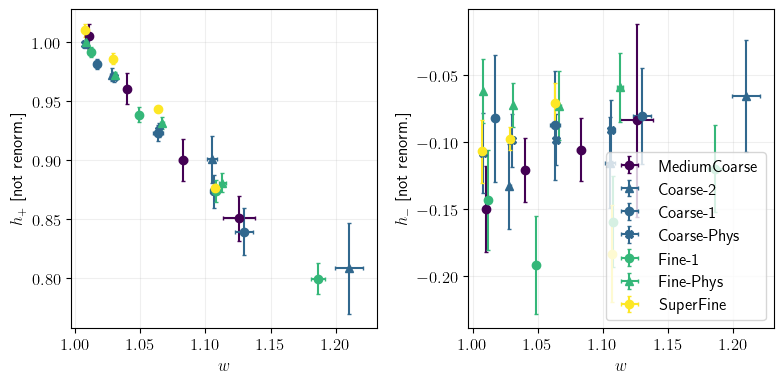

In [30]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)


# color = plt.cm.viridis(np.linspace(0,1,len(ENSEMBLE_LIST)))
color = plt.cm.viridis(np.linspace(0,1,4))

kwargs = {
    'MediumCoarse': dict(fmt='o',color=color[0], ecolor=color[0] ),
    'Coarse-1'    : dict(fmt='o',color=color[1], ecolor=color[1] ),
    'Coarse-2'    : dict(fmt='^',color=color[1], ecolor=color[1] ), 
    'Coarse-Phys' : dict(fmt='X',color=color[1], ecolor=color[1] ),
    'Fine-1'      : dict(fmt='o',color=color[2], ecolor=color[2] ),
    'Fine-Phys'   : dict(fmt='^',color=color[2], ecolor=color[2] ),
    'SuperFine'   : dict(fmt='o',color=color[3], ecolor=color[3] ),
}



for i,ens in enumerate(ENSEMBLE_LIST):
    ax[0].errorbar(
        gv.mean(ff['w' ].loc[ens].values),
        gv.mean(ff['h+'].loc[ens].values),
        xerr = gv.sdev(ff['w' ].loc[ens].values),
        yerr = gv.sdev(ff['h+'].loc[ens].values),
        # fmt     = 'o',
        # ecolor  = color[i],
        # mfc     = 'w', 
        # color   = color[i], 
        capsize = 1.5,
        label   = ens,
        **kwargs[ens]
    )

    ax[1].errorbar(
        gv.mean(ff['w' ].loc[ens].values),
        gv.mean(ff['h-'].loc[ens].values),
        xerr = gv.sdev(ff['w' ].loc[ens].values),
        yerr = gv.sdev(ff['h-'].loc[ens].values),
        # fmt     = 'o',
        # ecolor  = color[i],
        # mfc     = 'w', 
        # color   = color[i], 
        capsize = 1.5,
        label   = ens,
        **kwargs[ens]
    )

ax[0].set_ylabel(r'$h_+$ [not renorm.]')
ax[0].set_xlabel(r'$w$')
ax[0].grid(alpha=0.2)

ax[1].legend()
ax[1].set_ylabel(r'$h_-$ [not renorm.]')
ax[1].set_xlabel(r'$w$')
ax[1].grid(alpha=0.2)

plt.tight_layout()